### Instructions

**Part A)**

0) We ask you to create a folder for you project, in which you will be working on the project. You will be asked to send us this project that we can look at your progress and browse through your work. Please follow the instructions in the seminar or a documentation of julia about the activation of an environment and use it for your project. (It can be found also here: https://pkgdocs.julialang.org/v1/environments/ even it is from prompt/terminal, in a notebook use `Pkg.activate(".")`) 
* In your project, you will be adding packages, using them, you can create a script files as well and load them (with helper functions if needed.)


1) Use package `MarketData`, `Quandl`, or different one, if needed go to their github pages and `docs`, then **download data for an asset** of your choice.
2) Use plot to look at the data, do some summary statistics, `Statistics`, `DataFrames`, `StatsPlots` packages
3) Use GARCH to **model** asset data and **forecast**.
3) **Plot** forecasts.
    
This part is for you to get you familiar with julia, its syntax, and pacakges.

---

### 0.

#### Environment activation

In [1]:
#Activate the environment
using Pkg
Pkg.activate(".")

  Activating project at `d:\My stuff\School\Master\3. semestr\Financial Econometrics II\Project 1`


#### Loading required packages

In [ ]:
#Load required packages
using MarketData
using Statistics
using DataFrames
using StatsPlots
using GARCH

### 1.

We have chosen the McDonald's stock price as the variable of interest. We will download it from Yahoo Finance.

In [ ]:
#Download data for McDonald's stock from Yahoo (37.6s)
MCD = yahoo("MCD");

We are interested only in the adjusted close price so we will store it in a variable.

In [33]:
#Store only the Adjusted Close price
MCD_adj_close = values(MCD[:AdjClose]);

### 2.

In this section we provide sume fundamental summary statistics.

In [37]:
#Print summary statistics
n(x) = size(x)[1] #Define a function calculating the number of observations
quantile_5(x) = quantile(x, 0.05) #Define a function calculating the 5th percentile
quantile_25(x) = quantile(x, 0.25) #Define a function calculating the 25th percentile
quantile_75(x) = quantile(x, 0.75) #Define a function calculating the 75th percentile
quantile_95(x) = quantile(x, 0.95) #Define a function calculating the 95th percentile
skewness(x) = sum((x .- mean(x)) .^ 3) / (size(x)[1] * std(x) ^ 3) #Define a function calculating skewness
kurtosis(x) = sum((x .- mean(x)) .^ 4) / (size(x)[1] * std(x) ^ 4) #Define a function calculating skewness 
sum_stats = [n, mean, std, quantile_5, quantile_25, median, quantile_75, quantile_95, skewness, kurtosis] #Store the functions caclulating summary statistics into a vector for looping
str_info = ["Number of observations: ", "Mean: ", "Standard deviation: ", "5th percentile: ", "25th percentile: ", "Median: ", "75th percentile: ", "95th percentile: ", "Skewness: ", "Kurtosis: "] #Define strings to be printed
for i in range(1, size(sum_stats)[1])
    println(str_info[i] * string(round(sum_stats[i](MCD_adj_close), digits = 2)))
end


Number of observations: 13034.0
Mean: 37.87
Standard deviation: 59.77
5th percentile: 0.49
25th percentile: 1.23
Median: 12.59
75th percentile: 42.63
95th percentile: 194.35
Skewness: 2.06
Kurtosis: 6.48


We can also plot the time series. We can see that there is an obvious trend and as is common for asset prices, it is not stationary.

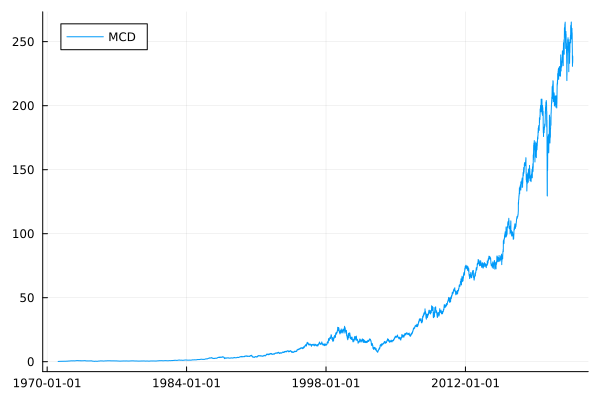

In [43]:
#Plotting the time series
plot(MCD[:AdjClose], labels = "MCD", legend = :topleft)

The histogram indicates that the series is positively skewed. This corresponds to the positive skewness calculated in the summary statistics.

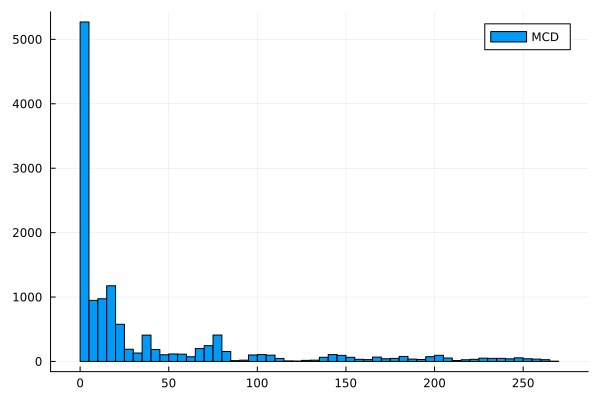

In [41]:
histogram(MCD[:AdjClose], labels = "MCD")

#### 3. 

In this section we estimate a GARCH model using the returns on the MCD's asset. We can see that all the estimated coefficients are statistically significant.

In [50]:
#Estimating GARCH
MCD_ret = diff(log.(MCD_adj_close))
MCD_fit = garchFit(MCD_ret)

Fitted garch model 
 * Coefficient(s):    ω              α              β              
                      2.0202e-06     0.054977       0.9384         
 * Log Likelihood: 36582
 * Converged: true
 * Solver status: XTOL_REACHED

 * Standardised Residuals Tests:
                             Statistic      p-Value        
   Jarque-Bera Test     χ²   4123.8         0              

 * Error Analysis:
          Estimate       Std.Error      t value        Pr(>|t|)       
   ω      2.0202e-06     2.6191e-07     7.7135         1.2212e-14     
   α      0.054977       0.0034735      15.828         0              
   β      0.9384         0.0037789      248.32         0              


#### 4.

In this section we make forecasts using the estimated model and plot them.

In [51]:
#Make forecasts
MCD_forecasts = predict(MCD_fit)

0.01319364177032228

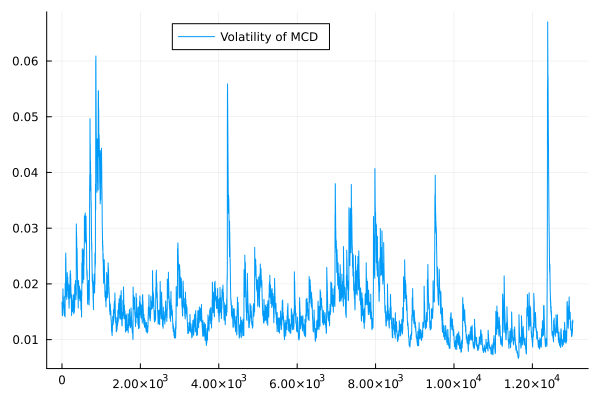

In [58]:
plot(MCD_fit.sigma, labels = "Volatility of MCD", legend = :top)